Dataset Download and Extraction

In [ ]:
import os
import subprocess
from zipfile import ZipFile

In [ ]:
def download_and_extract_oasis(data_dir="/content/data", zip_name="imagesoasis.zip"):
    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_path,
        "https://www.kaggle.com/api/v1/datasets/download/ninadaithal/imagesoasis"
    ], check=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(data_dir, "imagesoasis"))

    print(f"Dataset downloaded and extracted to: {os.path.join(data_dir, 'imagesoasis')}")

In [ ]:
download_and_extract_oasis()

Dataset downloaded and extracted to: /content/data/imagesoasis


In [ ]:
import os, re, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from IPython.display import display

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [ ]:
CLASS_MAP = {
    "Non Demented": 0,
    "Very mild Dementia": 1,
    "Mild Dementia": 2,
    "Moderate Dementia": 3
}


Data Loading and Preprocessing

In [ ]:
def load_all_oasis_data(root="/content/data/imagesoasis/Data"):
    records = []
    pattern = re.compile(r"^(OAS1_\d+)_MR\d+.*_(\d+)\.jpg$", re.IGNORECASE)
    for cname, label in CLASS_MAP.items():
        class_dir = os.path.join(root, cname)
        if not os.path.exists(class_dir):
            print(f"Skipping missing folder: {class_dir}")
            continue

        for path, _, files in os.walk(class_dir):
            for f in files:
                if not f.lower().endswith(".jpg"):
                    continue
                m = pattern.match(f)
                if not m:
                    continue
                pid, slice_idx = m.groups()
                patient_id = pid.split('_')[1] if '_' in pid else pid
                records.append({
                    "path": os.path.join(path, f),
                    "class": cname,
                    "label": label,
                    "patient": patient_id,
                    "slice": int(slice_idx)
                })

    df = pd.DataFrame(records)
    print(f"Loaded {len(df)} images from {len(CLASS_MAP)} classes "
          f"({df['patient'].nunique()} patients)")
    return df



In [ ]:
df = load_all_oasis_data()

Loaded 86437 images from 4 classes (347 patients)


In [ ]:
df.head()

,path,class,label,patient,slice
0,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented,0,0111,107
1,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented,0,0146,107
2,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented,0,0376,150
3,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented,0,0058,118
4,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented,0,0285,148


Exploratory Data Analysis

In [ ]:
print(f"Total images: {len(df)}")
print(f"Total patients: {df['patient'].nunique()}\n")

Total images: 86437
Total patients: 347



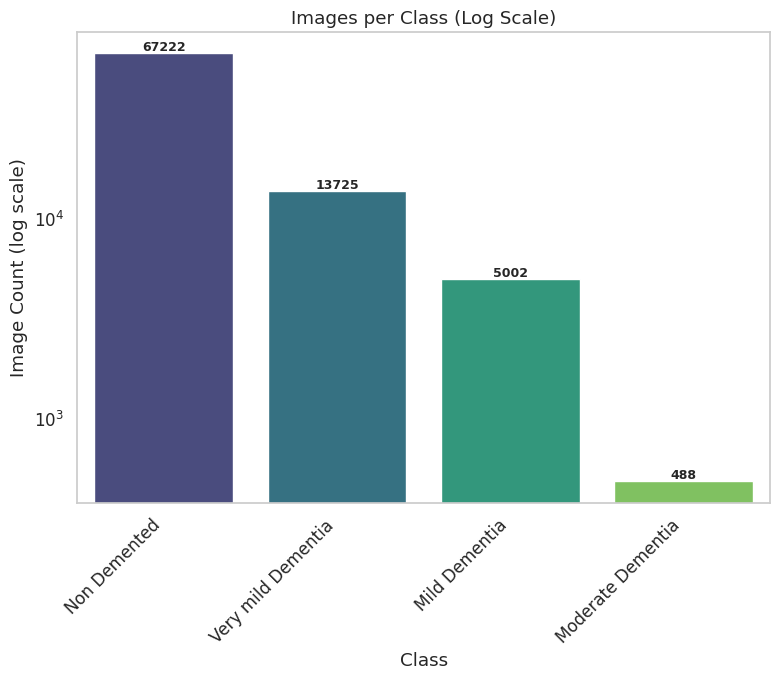

In [ ]:
img_counts = df['class'].value_counts().reset_index()
img_counts.columns = ['Class', 'Count']

plt.figure(figsize=(8,7))
sns.barplot(data=img_counts, x='Class', y='Count', hue='Class',
            dodge=False, palette='viridis', legend=False)

plt.yscale('log')
plt.title("Images per Class (Log Scale)")
plt.ylabel("Image Count (log scale)")
plt.xlabel("Class")
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(img_counts['Count']):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)
plt.tight_layout()
plt.grid(False)
plt.show()


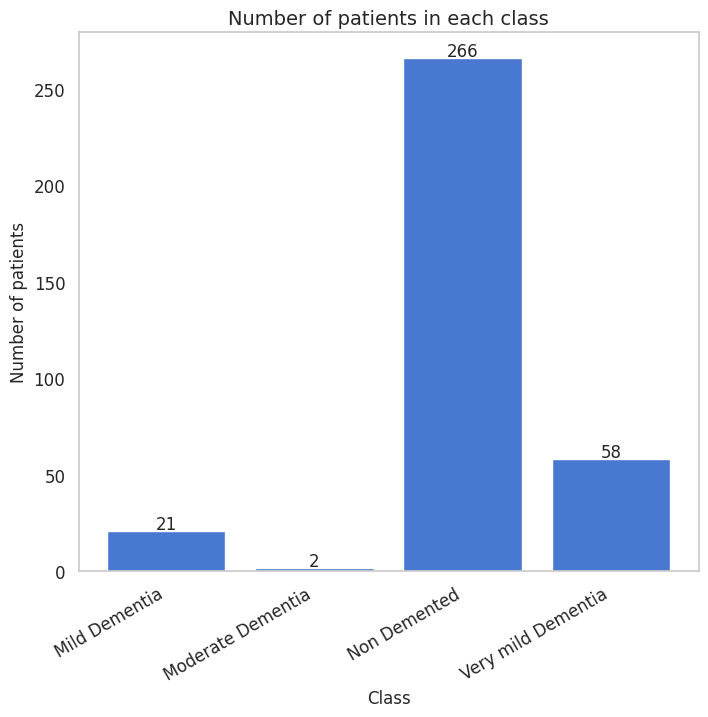

In [ ]:
classes = df.groupby('class')['patient'].nunique().index
patient_counts = df.groupby('class')['patient'].nunique().values

plt.figure(figsize=(8, 7))
plt.bar(classes, patient_counts)
plt.title('Number of patients in each class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of patients', fontsize=12)

for i, value in enumerate(patient_counts):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

plt.xticks(rotation=30, ha='right')
plt.grid(False)
plt.show()

In [ ]:
dup_paths = df[df.duplicated(subset='path', keep=False)]

if len(dup_paths) > 0:
    print(f"Found {len(dup_paths)} duplicated image entries.")
    display(dup_paths.head())
else:
    print("No duplicated image paths found.")


No duplicated image paths found.


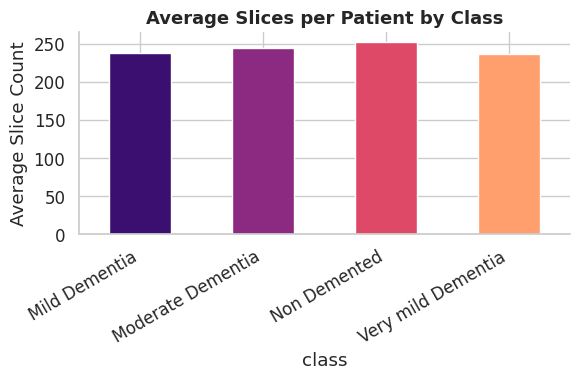

In [ ]:
avg_slices = df.groupby('class')['slice'].count() / df.groupby('class')['patient'].nunique()
avg_slices.plot(kind='bar', color=sns.color_palette('magma', len(avg_slices)), figsize=(6,4))
plt.title("Average Slices per Patient by Class", fontsize=13, fontweight='bold')
plt.ylabel("Average Slice Count")
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.show()


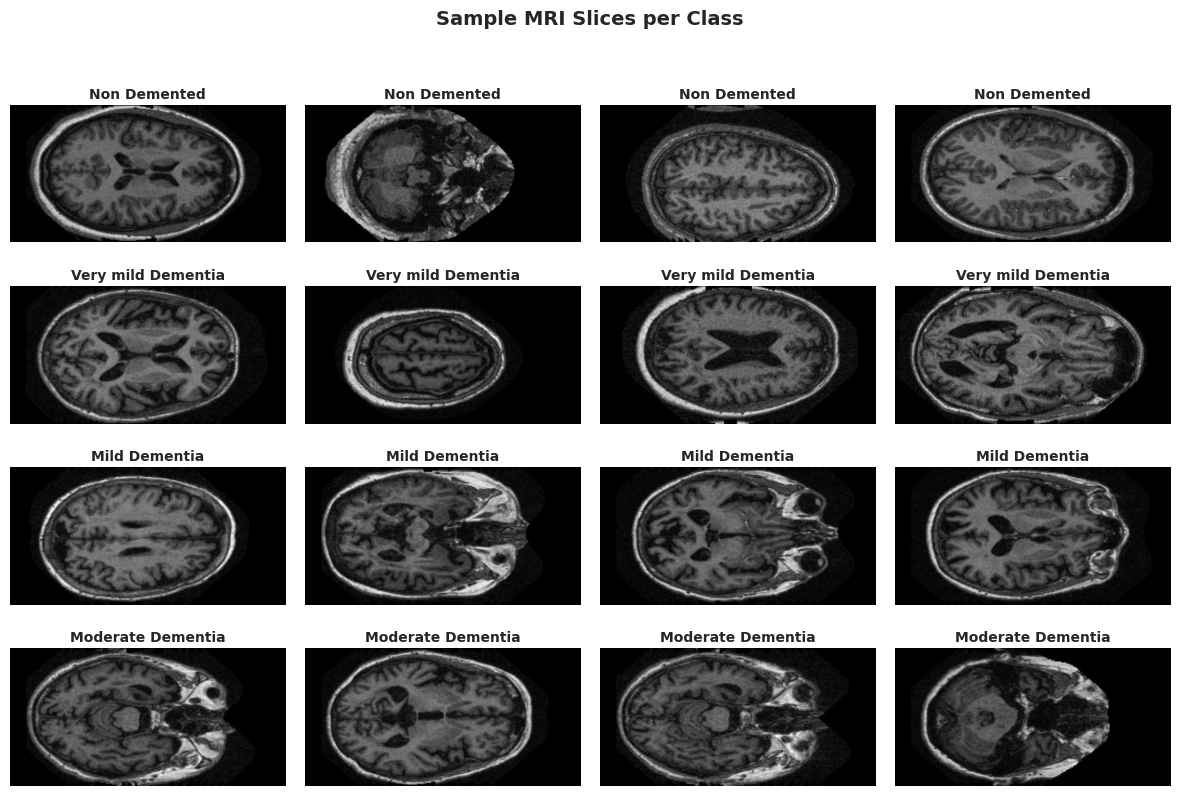

In [ ]:
plt.figure(figsize=(12, 8))

for i, c in enumerate(df['class'].unique()):
    subset = df[df['class'] == c].sample(4, random_state=42)

    for j, (_, row) in enumerate(subset.iterrows()):
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(CLASS_MAP), 4, i*4 + j + 1)
        plt.imshow(img)
        plt.axis('off')

        plt.title(c, fontsize=10, fontweight='bold', pad=5)

plt.suptitle("Sample MRI Slices per Class", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
summary = df.groupby('class').agg(
    total_images=('path', 'count'),
    unique_patients=('patient', 'nunique'),
    avg_slices_per_patient=('slice', 'count')
).reset_index()

display(summary)


,class,total_images,unique_patients,avg_slices_per_patient
0,Mild Dementia,5002,21,5002
1,Moderate Dementia,488,2,488
2,Non Demented,67222,266,67222
3,Very mild Dementia,13725,58,13725


Data splitting

In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)



In [ ]:
print(f"Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}")

# Class distribution check
print("\nClass Distribution (Train):")
display(train_df['class'].value_counts())
print("\nClass Distribution (Val):")
display(val_df['class'].value_counts())
print("\nClass Distribution (Test):")
display(test_df['class'].value_counts())


Train: 60505  |  Val: 12966  |  Test: 12966

Class Distribution (Train):


,count
class,
Non Demented,47055
Very mild Dementia,9607
Mild Dementia,3501
Moderate Dementia,342



Class Distribution (Val):


,count
class,
Non Demented,10083
Very mild Dementia,2059
Mild Dementia,751
Moderate Dementia,73



Class Distribution (Test):


,count
class,
Non Demented,10084
Very mild Dementia,2059
Mild Dementia,750
Moderate Dementia,73


In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='path', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)


Found 60505 validated image filenames belonging to 4 classes.
Found 12966 validated image filenames belonging to 4 classes.
Found 12966 validated image filenames belonging to 4 classes.


##### **Transfer Learning**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [ ]:
train_paths = train_df["path"].values
train_labels = train_df["label"].values

val_paths = val_df["path"].values
val_labels = val_df["label"].values

test_paths = test_df["path"].values
test_labels = test_df["label"].values


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img, tf.one_hot(label, NUM_CLASSES)

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(2000)
    .map(decode_image, AUTOTUNE)
    .map(augment, AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(decode_image, AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(decode_image, AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


##### **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19

def build_vgg19():
    base = VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")
    ])
    return model


In [ ]:
model = build_vgg19()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 173s 83ms/step - accuracy: 0.7575 - loss: 0.7525 - val_accuracy: 0.7776 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 2/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.7784 - loss: 0.6497 - val_accuracy: 0.7729 - val_loss: 0.6536 - learning_rate: 1.0000e-04
Epoch 3/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.7781 - loss: 0.6327 - val_accuracy: 0.7727 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 4/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.7773 - loss: 0.6227 - val_accuracy: 0.7777 - val_loss: 0.6329 - learning_rate: 1.0000e-04
Epoch 5/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.7786 - loss: 0.6136 - val_accuracy: 0.7784 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 6/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.7792 - loss: 0.6097 - val_accuracy: 0.7685 - val_loss: 0.6650 - learning_rate: 1.0000e-04
Epoch 7/15
1891/1891 ━━━━━━━━━━━━━

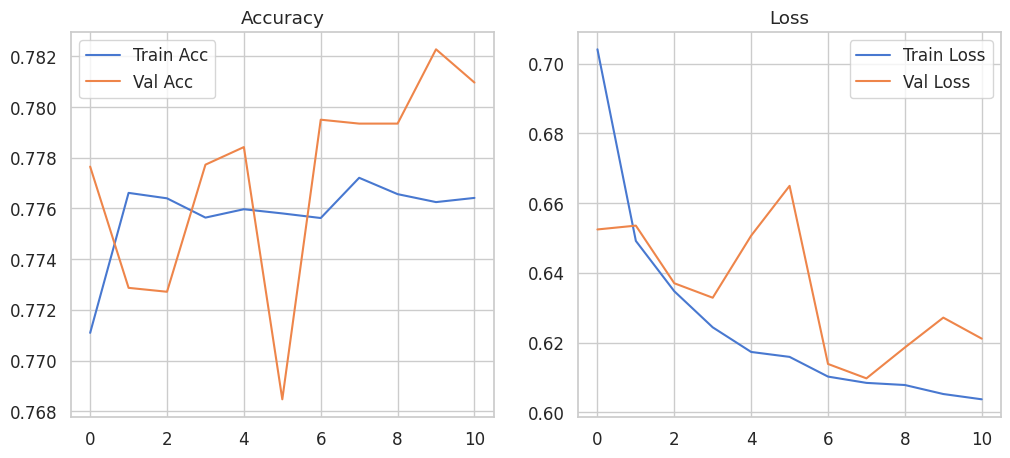

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.7773 - loss: 0.6075
Test Accuracy: 0.776646614074707


In [ ]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                            target_names=list(CLASS_MAP.keys())))


406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.81      0.95      0.88     10084
Very mild Dementia       0.42      0.23      0.30      2059
     Mild Dementia       0.20      0.00      0.01       750
 Moderate Dementia       0.00      0.00      0.00        73

          accuracy                           0.78     12966
         macro avg       0.36      0.30      0.29     12966
      weighted avg       0.71      0.78      0.73     12966



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


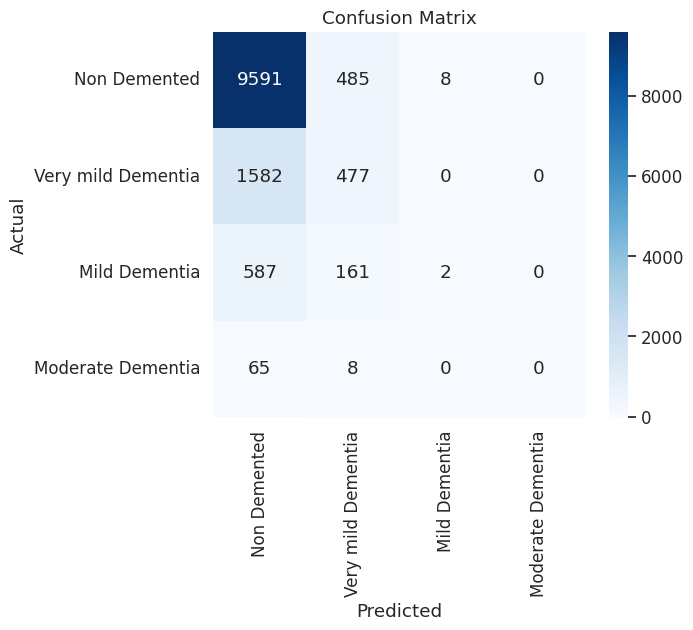

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(CLASS_MAP.keys()),
            yticklabels=list(CLASS_MAP.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


##### **Densenet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121

def build_densenet121():
    base = DenseNet121(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")
    ])
    return model


In [ ]:
model2 = build_densenet121()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model2.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-6)
]

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 218s 94ms/step - accuracy: 0.7247 - loss: 0.8364 - val_accuracy: 0.7802 - val_loss: 0.5744 - learning_rate: 1.0000e-04
Epoch 2/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 118s 62ms/step - accuracy: 0.7786 - loss: 0.5892 - val_accuracy: 0.7849 - val_loss: 0.5484 - learning_rate: 1.0000e-04
Epoch 3/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 167s 75ms/step - accuracy: 0.7800 - loss: 0.5638 - val_accuracy: 0.7865 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 4/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 111s 59ms/step - accuracy: 0.7817 - loss: 0.5531 - val_accuracy: 0.7931 - val_loss: 0.5106 - learning_rate: 1.0000e-04
Epoch 5/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 114s 60ms/step - accuracy: 0.7859 - loss: 0.5423 - val_accuracy: 0.8052 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 6/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 139s 58ms/step - accuracy: 0.7880 - loss: 0.5324 - val_accuracy: 0.8035 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 7/15
1891/1891 ━━━━━━━━━━━━━

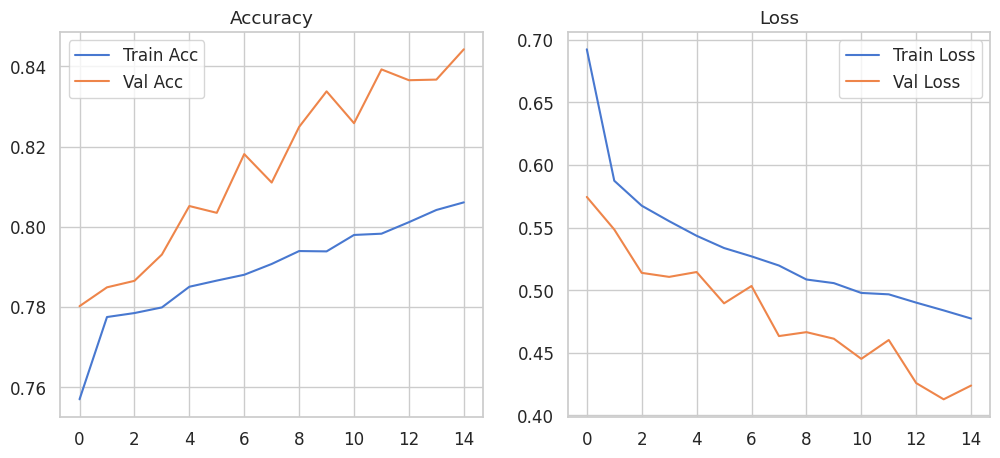

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
test_loss, test_acc = model2.evaluate(test_ds)
print("Test Accuracy:", test_acc)


406/406 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8383 - loss: 0.4035
Test Accuracy: 0.834721565246582


In [ ]:
y_true = test_labels
y_pred = np.argmax(model2.predict(test_ds), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                            target_names=list(CLASS_MAP.keys())))

406/406 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.84      0.98      0.91     10084
Very mild Dementia       0.73      0.37      0.49      2059
     Mild Dementia       0.82      0.21      0.34       750
 Moderate Dementia       1.00      0.18      0.30        73

          accuracy                           0.83     12966
         macro avg       0.85      0.44      0.51     12966
      weighted avg       0.83      0.83      0.80     12966



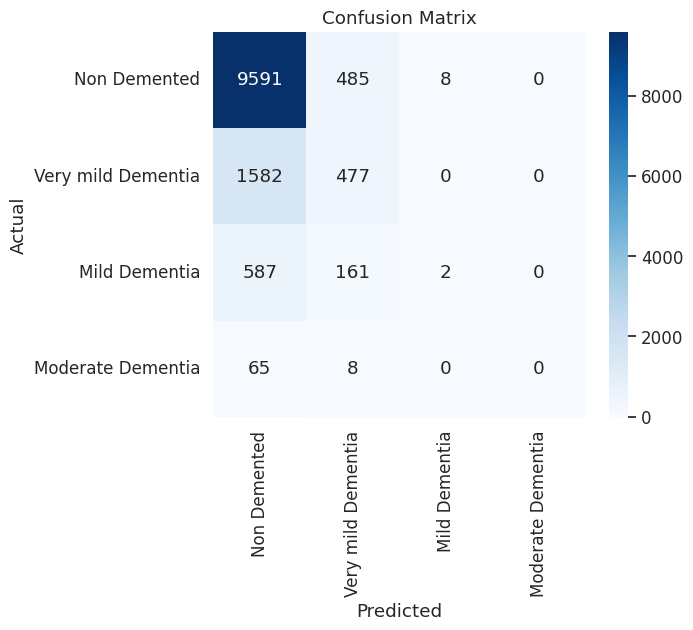

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(CLASS_MAP.keys()),
            yticklabels=list(CLASS_MAP.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
